In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow as pa
import pyarrow.parquet as pq
import geopandas as gpd
import seaborn as sns

#Packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
from scipy import stats
pd.set_option('display.max_columns', None)

In [60]:
df = pd.read_csv('filtered_csv_for_6ft_w_statistics.csv', low_memory = False)
df = df.drop(df.columns[0], axis=1)

df[(df['buildingPropertyValue'] >= 10000) & (df['buildingPropertyValue'] < 10000000)]


df = df[df['medWaterDepth'] < 20]


df['bool95'] = df['proportionLeqOne'] >= .95
df['bool90'] = df['proportionLeqOne'] >= .9
df['bool80'] = df['proportionLeqOne'] >= .8
df['bool75'] = df['proportionLeqOne'] >= .75
df['bool50'] = df['proportionLeqOne'] >= .5



In [61]:


# Assuming 'df' is your DataFrame and 'elevationDifference' is the column name

# Step 1: Impute missing values with mean imputation
mean_imputation = df['elevationDifference'].mean()
df['elevationDifference'] = df['elevationDifference'].fillna(mean_imputation)

# Step 2: Remove outliers
z_scores = np.abs((df['elevationDifference'] - df['elevationDifference'].mean()) / df['elevationDifference'].std())
threshold = 3  # Adjust the threshold as needed
df = df[z_scores <= threshold]

# Step 3: Create categorical bins
num_bins = 10
df['elevationDifference_category'] = pd.cut(df['elevationDifference'], bins=num_bins, labels=False)

# Optional: Rename the categories to meaningful labels
category_labels = ['Category 1', 'Category 2', 'Category 3', 'Category 4', 'Category 5',
                   'Category 6', 'Category 7', 'Category 8', 'Category 9', 'Category 10']
df['elevationDifference_category'] = df['elevationDifference_category'].map(lambda x: category_labels[x])



In [62]:
desired_variables = ['floodEvent', 'ratedFloodZone', 
                     'causeOfDamage', 'yearOfLoss', 'state', 'yearOfLoss',  'relativeDamage',
                     'AgeofBuildinguntilflood',
                     'postFIRMConstructionIndicator', 'elevatedBuildingIndicator', 'occupancyType' , 'floodproofedIndicator', 'rateMethod', 'proportionLeqOne', 
                     'bool75', 'bool50', 'bool80', 'bool90',   'elevationDifference_category', 'medWaterDepth']

df_new = df[desired_variables]



In [63]:
# Specify the variables to one-hot encode
variables_to_encode = ['floodEvent','floodEvent', 'ratedFloodZone', 
                       'causeOfDamage', 'state', 'yearOfLoss', 'occupancyType', 'floodproofedIndicator', 'rateMethod',  'elevationDifference_category']

#variables excluding: smallBusinessIndicatorBuilding', 'buildingDamageAmount', ,'stateOwnedIndicator', 'rateMethod', 'rentalPropertyIndicator' , floodWaterDuration 
#, 'p75WaterDepth',  'p90WaterDepth','diff90WaterDepth' 'proportionLeqTwo',
      # 'proportionLeqThree', 'proportionLeqFour', 'proportionLeqFive',
      # 'proportionLeqSix','p25WaterDepth', 'originalConstructionDateYear',  'diffMedWaterDepth', 'medWaterDepth'

# Perform one-hot encoding
df_encoded = pd.get_dummies(df_new, columns=variables_to_encode)

# Include the non-one-hot encoded variables from the original dataframe
variables_to_include = ['AgeofBuildinguntilflood',   'postFIRMConstructionIndicator', 'elevatedBuildingIndicator', 'relativeDamage', 'proportionLeqOne',  'bool75', 'bool50', 'bool80', 'bool90', 'medWaterDepth']
df_encoded[variables_to_include] = df[variables_to_include]

In [64]:
from sklearn.preprocessing import StandardScaler

# Specify the variables to normalize
variables_to_normalize = ['AgeofBuildinguntilflood', 'relativeDamage', 'proportionLeqOne',  'medWaterDepth']

# Create a scaler object
scaler = StandardScaler()

# Normalize the variables
df_encoded[variables_to_normalize] = scaler.fit_transform(df_encoded[variables_to_normalize])

In [65]:
from pyod.models.ecod import ECOD


clf = ECOD(contamination = .1)
clf.fit(df_encoded)

ECOD(contamination=0.1, n_jobs=1)

In [66]:
 y_train_pred = clf.labels_ 

In [67]:
sum(y_train_pred)

3411

In [68]:
len(y_train_pred)

34106

In [69]:
mask = y_train_pred == 1

# Apply the mask to filter the DataFrame
filtered_df = df[mask]

In [70]:
filtered_df['relativeDamage'].mean()

0.1950858842982434

In [71]:
filtered_df['proportionLeqOne'].mean()

0.5163731632220445

In [72]:
filtered_df['buildingPropertyValue'].mean()

325932.6352975667

In [73]:
dfIso = pd.read_csv('IsolationForestAnomalies_2.csv')

In [74]:
merged_df = dfIso.merge(filtered_df, on='id', how='inner')

In [75]:
len(merged_df)

1676

In [76]:
1676/3411

0.4913515098211668

In [77]:
merged_df['relativeDamage_x'].mean()

0.18412919721279086

In [78]:
merged_df['proportionLeqOne_x'].median()

0.6180344478216819

In [79]:
sum(merged_df['proportionLeqOne_x'] >= .52)

990

In [80]:
merged_df['buildingPropertyValue_x'].mean()

321018.8311455847

In [81]:
sum(merged_df['proportionLeqOne_x'] <.2 )

205

In [82]:
dfIso['buildingPropertyValue'].mean()

278954.3163295221

In [83]:
filtered_df[filtered_df['buildingPropertyValue'] <= 200000]['relativeDamage'].mean()

0.22527113202229906

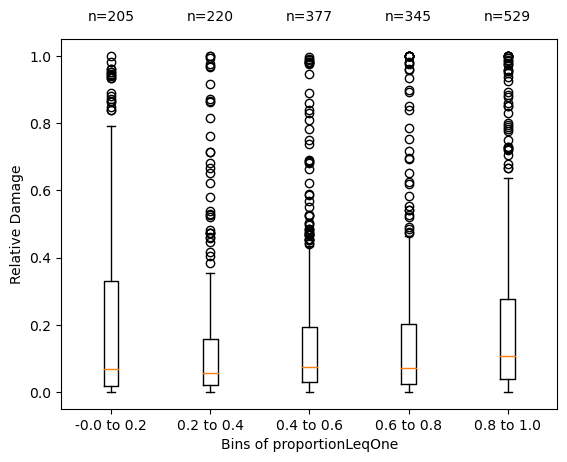

In [84]:

# Define the number of bins and the bin edges
num_bins = 5
bin_edges = pd.cut(merged_df['proportionLeqOne_x'], bins=num_bins)

# Group the data by the bins
grouped_data = merged_df.groupby(bin_edges)

# Create a figure and axis for the boxplots
fig, ax = plt.subplots()

# Create a list to store the positions of each boxplot
positions = []

# Store the labels for the bins
bin_labels = []

# Iterate over the groups and create boxplots
for i, (group, data) in enumerate(grouped_data):
    positions.append(i+1)
    # count the number of observations in the bin
    num_observations = len(data)
    # create the label for the bin
    bin_label = f'{group.left:.1f} to {group.right:.1f}'
    bin_labels.append(bin_label)
    ax.boxplot(data['relativeDamage_x'], positions=[i+1])
    
    # Annotate number of observations at the very top of the figure
    ax.text(i+1, 1.05, f'n={num_observations}', ha='center', transform=ax.get_xaxis_transform())

# Set the x-axis labels
ax.set_xticks(positions)
ax.set_xticklabels(bin_labels)

# Set the x-axis label
ax.set_xlabel('Bins of proportionLeqOne')

# Set the y-axis label
ax.set_ylabel('Relative Damage')


# Show the plot
plt.show()


In [97]:
from pyod.models.hbos import HBOS


clf = PCA(contamination = .1)
clf.fit(df_encoded)



PCA(contamination=0.1, copy=True, iterated_power='auto', n_components=None,
  n_selected_components=None, random_state=None, standardization=True,
  svd_solver='auto', tol=0.0, weighted=True, whiten=False)

In [98]:
y_train_pred = clf.labels_ 
mask = y_train_pred == 1

# Apply the mask to filter the DataFrame
filtered_pca = df[mask]

In [99]:
filtered_pca['relativeDamage'].mean()

0.25470766353141316

In [100]:
filtered_pca['proportionLeqOne'].mean()

0.3558847677974418

In [101]:
filtered_pca['buildingPropertyValue'].mean()

202759.9744942832

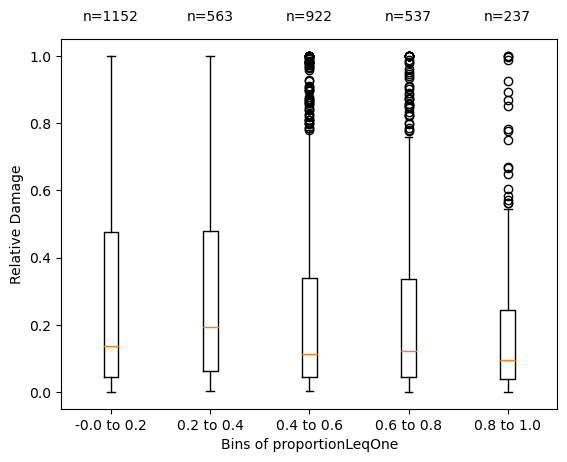

In [102]:

# Define the number of bins and the bin edges
num_bins = 5
bin_edges = pd.cut(filtered_pca['proportionLeqOne'], bins=num_bins)

# Group the data by the bins
grouped_data = filtered_pca.groupby(bin_edges)

# Create a figure and axis for the boxplots
fig, ax = plt.subplots()

# Create a list to store the positions of each boxplot
positions = []

# Store the labels for the bins
bin_labels = []

# Iterate over the groups and create boxplots
for i, (group, data) in enumerate(grouped_data):
    positions.append(i+1)
    # count the number of observations in the bin
    num_observations = len(data)
    # create the label for the bin
    bin_label = f'{group.left:.1f} to {group.right:.1f}'
    bin_labels.append(bin_label)
    ax.boxplot(data['relativeDamage'], positions=[i+1])
    
    # Annotate number of observations at the very top of the figure
    ax.text(i+1, 1.05, f'n={num_observations}', ha='center', transform=ax.get_xaxis_transform())

# Set the x-axis labels
ax.set_xticks(positions)
ax.set_xticklabels(bin_labels)

# Set the x-axis label
ax.set_xlabel('Bins of proportionLeqOne')

# Set the y-axis label
ax.set_ylabel('Relative Damage')


# Show the plot
plt.show()